In [1]:
import numpy as np
import os
import struct
import matplotlib.pyplot as plt
from math import log, sqrt, exp, pi, factorial, erf
%config InlineBackend.figure_format = 'svg'

In [2]:
def load_mnist(path, kind='train'):
    labels_path = os.path.join(path,'%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path,'%s-images.idx3-ubyte' % kind)
    
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)


    with open(images_path, 'rb') as imgpath:
        magic, n, rows, cols = struct.unpack('>IIII',
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(len(labels), 784)

    return images, labels, n

train_num, test_num : 60000 10000
labels [0] : 5 


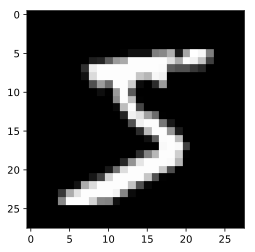

In [3]:
train_img, train_label, train_num= load_mnist("./img/", kind='train')
test_img, test_label, test_num = load_mnist("./img/", kind='t10k')
train_img = train_img.reshape(train_num, 28, 28)
test_img = test_img.reshape(test_num, 28, 28)

print("train_num, test_num :",train_num, test_num)
print("labels [0] : %d " % train_label[0])
plt.imshow(train_img[0], cmap="gray");

### In Discrete mode:
* Tally the frequency of the values of each pixel into 32 bins. For example, The gray
level of 0 to 7 should be classified to bin 0, gray level of 8 to 15 should be bin 1 ...
etc. Then perform Naive Bayes classifier. 
* Note that to avoid empty bin, you can
use a peudocount (such as the minimum value in other bins) for instead.

In [4]:
pixelCount = np.ones([10, 28*28, 32])
classCount = np.zeros(10)

for idx, data in enumerate(train_img):
    classCount[train_label[idx]] += 1
    for pixel in range(28*28):
        pixelCount[train_label[idx], pixel, (data[pixel//28, pixel%28] >> 3)] += 1

In [44]:
error_D = 0
Posterior_D = np.zeros([test_num, 10])
for idx, data in enumerate(test_img):
    for num in range(10):
        for pixel in range(28*28):
            Posterior_D[idx][num] += log(pixelCount[num][pixel][data[pixel//28, pixel%28]>>3]/classCount[num])
        
        Posterior_D[idx][num] += log(classCount[num]/60000)

    
    Posterior_D[idx] = Posterior_D[idx] / sum(Posterior_D[idx])
    
            
        
    predict = np.argmin(Posterior_D[idx])
    answer = test_label[idx]
    if predict != answer:
        error_D += 1

Wall time: 6min 58s


In [45]:
print(Posterior_D[0])
print(Posterior_D[1])
print(error_D)

[0.1112227  0.11782431 0.10520342 0.10015438 0.09383541 0.09747345
 0.11450876 0.07430164 0.09950319 0.08597274]
[0.10019628 0.10712789 0.0832433  0.09030893 0.10880589 0.09243522
 0.08960138 0.11904858 0.09630982 0.1129227 ]
1535


### In Continuous mode:
* Use MLE to fit a Gaussian distribution for the value of each pixel. Perform Naive
Bayes classifier.

In [48]:
pixelDatas = [[[] for _ in range(28*28)] for _ in range(10)]
for idx, data in enumerate(train_img):
    for pixel in range(28*28):
        pixelDatas[train_label[idx]][pixel].append(data[pixel//28, pixel%28])

In [92]:
def Gaussian(u, v):
    return lambda x : (exp(-1*(((x - u)**2) / (2*v) ) ) / sqrt(2*pi*v))

In [85]:
pixelGaussian = [[[0, 0] for _ in range(28*28)] for _ in range(10)]
Variance_zero = 1000
count = 0
for i in range(10):
    for j in range(28*28):
        u = sum(pixelDatas[i][j]) / classCount[i]
        v = sum([abs(x - u)**2 for x in pixelDatas[i][j]]) / classCount[i]
    
        pixelGaussian[i][j][0] = u
        if v <= Variance_zero:
            count += 1
            v = Variance_zero
        pixelGaussian[i][j][1] = v
        pixelGaussian[i][j].append(Gaussian(u, v))
        pixelGaussian[i][j].append(CDF(u, v))
print(count)

4348
Wall time: 2min 59s


In [95]:
error_G = 0
width_G = 1
Posterior_G = np.zeros([test_num, 10])
for idx, data in enumerate(test_img):
    for num in range(10):
        for pixel in range(28*28):
            Posterior_G[idx][num] += log(pixelGaussian[num][pixel][2](data[pixel//28, pixel%28]))

        Posterior_G[idx][num] += log(classCount[num]/60000)

    
    Posterior_G[idx] = Posterior_G[idx] / sum(Posterior_G[idx])
    
            
        
    predict = np.argmin(Posterior_G[idx])
    answer = test_label[idx]
    if predict != answer:
        error_G += 1
    if idx%100 == 0:
        print(idx)
#     print("predict, answer:", predict, answer)\]
#     print(Posterior_G[idx])
print(error_G)



0
100
200
300
400
500
600
700
800
900
1000


KeyboardInterrupt: 